In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import statistics

In [2]:
# Add path of your data on your local drive

df = pd.read_csv("train.csv")

In [3]:
# Clean input dataframe

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

# Create minute column
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minutes'] = df['dropoff_datetime'].dt.minute

# Create hour column
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Create day of week column
df['pickup_dow'] = df['pickup_datetime'].dt.weekday
df['dropoff_dow'] = df['dropoff_datetime'].dt.weekday

# Create day of month column
df['pickup_dom'] = df['pickup_datetime'].dt.day
df['dropoff_dom'] = df['dropoff_datetime'].dt.day

# Create month column
df['pickup_month'] = df['pickup_datetime'].dt.month
df['dropoff_month'] = df['dropoff_datetime'].dt.month

# Map 'Y' and 'N' in 'store_and_fwd_flag' as 1 and 0
store_and_fwd_map = {'Y':1,'N':0}
df = df.copy()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_and_fwd_map)

In [4]:
# Create missing data
random.seed(123)

# Insert nan values in pickup_hour
nan_pickup_hours = df['pickup_hour'].sample(round(df.shape[0]/41)).index
df.loc[nan_pickup_hours,'pickup_hour']=np.nan

# Insert nan values in dropoff_longitude
nan_dropoff_longitude = df['dropoff_longitude'].sample(round(df.shape[0]/37)).index
df.loc[nan_dropoff_longitude,'dropoff_longitude']=np.nan

In [5]:
# Approach 1 - Delete rows with missing values
# Pass only the dataframe as argument

def approach1_rem_msg(messy_df):
    clean_df = messy_df.dropna()
    rows_dropped = 1 - clean_df.shape[0]/messy_df.shape[0]
    return clean_df, rows_dropped

#------------------------------------------------------------------------------------------------------------------------

# Approach 2 - Impute missing values
# The following function imputes the missing values with mean/median/mode according to arguments passed
# User also has to pass as list the names of columns which have missing values 
# Call function  - approach2_impute_metric(<df>,<"mean">/<"median">/<"mode">,[<'missingcolname1'>,<'missingcolname2'])

def approach2_impute_metric(messy_df, metric, colnames):
    clean_df = messy_df.copy()    
    missing_list = []
    
    if metric=="mean":
        for col in colnames:
            imputenum = messy_df[col].mean()
            missing_count = messy_df[col].isnull().sum()
            missing_list.append([imputenum]*missing_count)
            clean_df[col] = messy_df[col].fillna(imputenum)            

    if metric=="median":
        for col in colnames:
            imputenum = messy_df[col].median()
            missing_count = messy_df[col].isnull().sum()  
            missing_list.append([imputenum]*missing_count)
            clean_df[col] = messy_df[col].fillna(imputenum)
    
    if metric=="mode":
        for col in colnames:
            imputenum = messy_df[col].mode()
            missing_count = messy_df[col].isnull().sum()
            missing_pos = clean_df[col].isnull()
            clean_df.loc[clean_df[col].isnull(),col] = np.random.choice(imputenum, missing_count)
            missing_list.append(clean_df.loc[missing_pos,col].tolist())    
        
    return clean_df, missing_list
 
#-------------------------------------------------------------------------------------------------------------------------

# Approach 3 - Predict missing values
    
def approach3_predict_msg(messy_df, metric, colnames):
    
    X_df = messy_df.drop(colnames, axis = 1)
    Y_df = messy_df[colnames]
    Y_pred_df = pd.DataFrame(columns=colnames)
    Y_missing_df = pd.DataFrame(columns=colnames)
    missing_list = []
    
    for col in messy_df[colnames]:
    
        missing_count = messy_df[col].isnull().sum()
    
        messy_df_train = messy_df[~messy_df[col].isnull()]
        msg_cols_train_df = messy_df_train[col]
        messy_df_train = messy_df_train.drop(colnames, axis = 1)

        messy_df_test = messy_df[messy_df[col].isnull()]
        msg_cols_test_df = messy_df_test[col]
        messy_df_test = messy_df_test.drop(colnames,axis = 1)

        Y_train = msg_cols_train_df.copy()
        X_train = messy_df_train.copy()
        
        if metric == "Linear Regression":
            model = LinearRegression()
            model.fit(X_train,Y_train)
            print("R-squared value is: " + str(model.score(X_train, Y_train)))
            
        elif metric == "Random Forests":
            model = RandomForestRegressor(n_estimators = 100 , oob_score = True)
            model.fit(X_train,Y_train) 
#            importances = model.feature_importances_
#             for name, importance in zip(X_train.columns, model.feature_importances_):
#                 print(name, "=", importance)
              
        X_test = messy_df_test.copy()
        Y_test = model.predict(X_test)
        
        Y_test_integer = pd.to_numeric(pd.Series(Y_test),downcast='integer')
        Y_complete = Y_train.append(Y_test_integer)
        Y_complete = Y_complete.reset_index(drop = True)
        
        missing_list.append(Y_test.tolist())
        
        Y_pred_df[col] = Y_complete
        Y_pred_df = Y_pred_df.reset_index(drop = True)
   
    clean_df = X_df.join(Y_pred_df)
    
    return clean_df,missing_list

In [6]:
def clean_performance_measure_df(df2):
    trip_duration_cutoff_mins = 20
    df2['trip_duration_encoded'] = 0
    df2.loc[df2['trip_duration']>=trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 1
    df2.loc[df2['trip_duration']<trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 0
    df2 = df2.drop(['dropoff_minutes','dropoff_hour',
                    'dropoff_dow','dropoff_dom','dropoff_month','trip_duration','dropoff_longitude','dropoff_latitude'], axis = 1)
    df2.dropna(inplace=True)
    return(df2)

In [7]:
def accuracy_determination(df2,algo, Y_col):
    df = clean_performance_measure_df(df2)
    y = df[Y_col]
    X = df.drop(Y_col, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if algo == "Logistic Regression":
        model = LogisticRegression()
        model.fit(X_train,y_train)
    elif algo == "Random Forests":
        model = RandomForestClassifier(n_estimators = 100 , oob_score = True)
        model.fit(X_train,y_train)
#        importances = model.feature_importances_
        for name, importance in zip(X_train.columns, model.feature_importances_):
            print(name, "=", importance)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [8]:
# # Test the approaches to missing data

df_test = df.drop(['id','pickup_datetime','dropoff_datetime'], axis = 1)
df_test = df_test.head(10000)

# # Call function to clean missing data

# # Approach 1 - delete rows containing missing values 
test_pred1, rows_dropped = approach1_rem_msg(df_test)

# # Get performance measure of Approach 1
test_pred1_logistic_accuracy = accuracy_determination(test_pred1,"Logistic Regression",'trip_duration_encoded')
test_pred1_rf_accuracy = accuracy_determination(test_pred1,"Random Forests",'trip_duration_encoded')

# #----------------------------------------------------------------------------------------------------------------------------

# # Approach 2 - Impute missing values

# #Part a - Impute with mean
test_pred2a, imputed_values2a = approach2_impute_metric(df_test,"mean",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2a
test_pred2a_logistic_accuracy = accuracy_determination(test_pred2a,"Logistic Regression",'trip_duration_encoded')
test_pred2a_rf_accuracy = accuracy_determination(test_pred2a,"Random Forests",'trip_duration_encoded')

# #Part b - Impute with median
test_pred2b, imputed_values2b = approach2_impute_metric(df_test,"median",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2b
test_pred2b_logistic_accuracy = accuracy_determination(test_pred2b,"Logistic Regression",'trip_duration_encoded')
test_pred2b_rf_accuracy = accuracy_determination(test_pred2b,"Random Forests",'trip_duration_encoded')

# #Part c - Impute with median
test_pred2c, imputed_values2c = approach2_impute_metric(df_test,"mode",['dropoff_longitude','pickup_hour'])
# # Get performance measure of Approach 2c
test_pred2c_logistic_accuracy = accuracy_determination(test_pred2c,"Logistic Regression",'trip_duration_encoded')
test_pred2c_rf_accuracy = accuracy_determination(test_pred2c,"Random Forests",'trip_duration_encoded')

#---------------------------------------------------------------------------------------------------------------------------

# # Approach 3 - Predict missing values

# #Part a - Predict using linear regression
test_pred3a, predicted_values3a = approach3_predict_msg(df_test,"Linear Regression",['dropoff_longitude','pickup_hour'])
test_pred3a_logistic_accuracy = accuracy_determination(test_pred3a,"Logistic Regression",'trip_duration_encoded')
test_pred3a_rf_accuracy = accuracy_determination(test_pred3a,"Random Forests",'trip_duration_encoded')

# Part b - Predict using Random Forests
test_pred3b, predicted_values3b = approach3_predict_msg(df_test,"Random Forests",['dropoff_longitude','pickup_hour'])
test_pred3b_logistic_accuracy = accuracy_determination(test_pred3b,"Logistic Regression",'trip_duration_encoded')
test_pred3b_rf_accuracy = accuracy_determination(test_pred3b,"Random Forests",'trip_duration_encoded')

/Users/sally/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sally/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


vendor_id = 0.023163610514
passenger_count = 0.0376751009044
pickup_longitude = 0.270008315943
pickup_latitude = 0.197177742635
store_and_fwd_flag = 0.00352514057015
pickup_minute = 0.134931281744
pickup_hour = 0.105865635552
pickup_dow = 0.0619872593003
pickup_dom = 0.114139835841
pickup_month = 0.051526076996
vendor_id = 0.0239708263666
passenger_count = 0.0369318490814
pickup_longitude = 0.265768348478
pickup_latitude = 0.209401316316
store_and_fwd_flag = 0.0036991400865
pickup_minute = 0.136204992452
pickup_hour = 0.106984253835
pickup_dow = 0.0588043103318
pickup_dom = 0.106891497458
pickup_month = 0.0513434655941
vendor_id = 0.0237836675129
passenger_count = 0.0365192135195
pickup_longitude = 0.266849872496
pickup_latitude = 0.212138791644
store_and_fwd_flag = 0.00351675382157
pickup_minute = 0.13374977918
pickup_hour = 0.10430403536
pickup_dow = 0.0590168733245
pickup_dom = 0.106721715303
pickup_month = 0.0533992978389
vendor_id = 0.0247776383659
passenger_count = 0.036770288101

In [9]:
print(test_pred1_logistic_accuracy,test_pred1_rf_accuracy)
print(test_pred2a_logistic_accuracy,test_pred2a_rf_accuracy)
print(test_pred2b_logistic_accuracy,test_pred2b_rf_accuracy)
print(test_pred2c_logistic_accuracy,test_pred2c_rf_accuracy)
print(test_pred3a_logistic_accuracy,test_pred3a_rf_accuracy)
print(test_pred3b_logistic_accuracy,test_pred3b_rf_accuracy)

0.802631578947 0.830263157895
0.80125 0.82475
0.80125 0.8245
0.80125 0.825
0.80125 0.82425
0.80125 0.825


In [10]:
# Compare missing value replacement approaches 

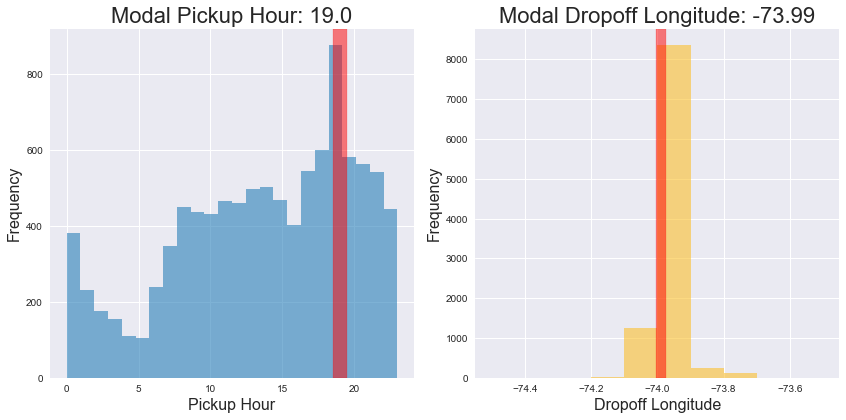

In [30]:
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
import missingno as msno

mean_pickup = test_pred2a['pickup_hour'].mean()
mean_dropoff = test_pred2a['dropoff_longitude'].mean()
median_pickup = test_pred2b['pickup_hour'].median()
median_dropoff = test_pred2b['dropoff_longitude'].median()
mode_pickup = test_pred2c['pickup_hour'].mode()
mode_dropoff = test_pred2c['dropoff_longitude'].mode()

# make 4 buttons
button1 = Button(description="Delete rows with missing values",
           layout=Layout(width='50%', height='50px'))
button2 = Button(description="Impute metric: Mean",
                layout=Layout(width='50%', height='50px'))
button3 = Button(description="Impute metric: Median",
                layout=Layout(width='50%', height='50px'))
button4 = Button(description="Impute metric: Mode",
                layout=Layout(width='50%', height='50px'))
button5 = Button(description="Predict values: Linear Regression",
                layout=Layout(width='50%', height='50px'))
button6 = Button(description="Predict values: Random Forests",
                layout=Layout(width='50%', height='50px'))
display(button1, button2, button3, button4, button5, button6)

# define button calls

def button1Clicked(b):
    clear_output()
    msno.matrix(df)
    msno.matrix(test_pred1)
    
def button2Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)
    plt.title("Mean Pickup Hour: "+str(round(mean_pickup,2)), fontsize=22)
    plt.hist(test_pred2a['pickup_hour'], 15, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(mean_pickup-.5, mean_pickup+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Mean Dropoff Longitude: "+str(round(mean_dropoff,2)), fontsize=22)
    plt.hist(test_pred2a['dropoff_longitude'], 10, range=[-74.5, -73.5], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(mean_dropoff-.015, mean_dropoff+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_mean.png', bbox_inches='tight')
    plt.show()
    
def button3Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))  
    
    plt.subplot(1, 2, 1)
    plt.title("Median Pickup Hour: "+str(round(median_pickup,2)), fontsize=22)
    plt.hist(test_pred2b['pickup_hour'], 15, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(median_pickup-.5, median_pickup+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Median Dropoff Longitude: "+str(round(mean_dropoff,2)), fontsize=22)
    plt.hist(test_pred2b['dropoff_longitude'], 10, range=[-74.5, -73.5], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(median_dropoff-.015, median_dropoff+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_median.png', bbox_inches='tight')
    plt.show()
    
def button4Clicked(b):
    clear_output()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Modal Pickup Hour: "+str(round(mode_pickup[0],2)), fontsize=22)
    plt.hist(test_pred2c['pickup_hour'], 24, color="#2980B9", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Pickup Hour", fontsize=16)
    plt.axvspan(mode_pickup[0]-.5, mode_pickup[0]+.5, color='red', alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Modal Dropoff Longitude: "+str(round(mode_dropoff[0],2)), fontsize=22)
    plt.hist(test_pred2c['dropoff_longitude'], 10, range=[-74.5, -73.5], color="#FBC02D", alpha=0.6)
    plt.ylabel("Frequency", fontsize=16) 
    plt.xlabel("Dropoff Longitude", fontsize=16)
    plt.axvspan(mode_dropoff[0]-.015, mode_dropoff[0]+.015, color='red', alpha=0.5)
    
    plt.tight_layout()
    
    # plt.savefig('impute_mode.png', bbox_inches='tight')
    
    plt.show()
    
# specify which functions to be called when buttons are clicked
button1.on_click(button1Clicked)
button2.on_click(button2Clicked)
button3.on_click(button3Clicked)
button4.on_click(button4Clicked)

In [ ]:
# Test code below - Do not run 6,7,10,16,17

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10 , oob_score = True)
model.fit(X,Y)

In [ ]:
model_features = pd.Series(model.feature_importances_,X.columns)
model_features.sort_values
model_features.plot(kind="barh",figsize=(7,6))

In [ ]:
model.feature_importances_